---
# Cairo University Faculty of Engineering
## Machine Learning
## Assignment 3

---

Please write your full name here
- **Name** : Mohamed El-Sayed Eid

In [56]:
%matplotlib notebook
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


np.random.seed(0)

### Part 1
Run the following cells to download fmnist dataset which will be used for the rest of the assignment.

In [57]:
# %pip install openml

# General imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openml as oml
from matplotlib import cm


In [58]:
# Download FMINST data. Takes a while the first time.
fmnist = oml.datasets.get_dataset(40996)
X, y, _, _ = fmnist.get_data(target=fmnist.default_target_attribute);
fmnist_classes = {0:"T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal",
                  6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

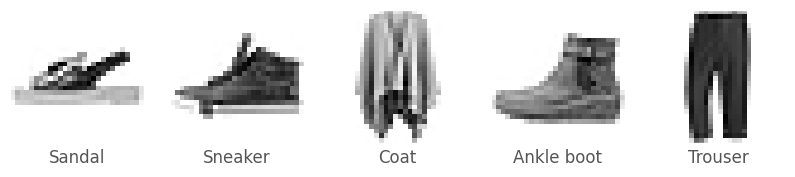

In [59]:
# Take some random examples, reshape to a 32x32 image and plot
from random import randint
IMG_COUNT = 5
fig, axes = plt.subplots(1, IMG_COUNT,  figsize=(10, 5))
for i in range(IMG_COUNT):
    n = randint(0,70000)
    axes[i].imshow(X.values[n].reshape(28, 28), cmap=plt.cm.gray_r)
    axes[i].set_xlabel((fmnist_classes[int(y.values[n])]))
    axes[i].set_xticks(()), axes[i].set_yticks(())
plt.show();

### Question 1
First, we'll try the default Logistic Regression and k-Nearest Neighbors as a point of reference. To see whether our models are overfitting, we also evaluate the training set error. This can be done using cross_validation.

Implement the following `evaluate_learners` function which evaluates each classifier passed into it on the given data, and then returns both the train and test scores of each as a list. You must use `cross_validate` function.

In [60]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# Take a 10% stratified subsample to speed up experimentation
Xs, _, ys, _ = train_test_split(X,y, stratify=y, train_size=0.1, random_state =0)
scalar = StandardScaler().fit(Xs)
Xs_scaled = scalar.transform(Xs)

In [61]:
def evaluate_learners(classifiers, X, y):
    """ Evaluate each classifier in 'classifiers' with cross-validation on the provided (X, y) data.

    Given a list of scikit-learn classifiers [Classifier1, Classifier2, ..., ClassifierN] return two lists:
     - a list with the scores obtained on the training samples for each classifier,
     - a list with the test scores obtained on the test samples for each classifier.
     The order of scores should match the order in which the classifiers were originally provided. E.g.:
     [Classifier1 train score, ..., ClassifierN train score], [Classifier1 test score, ..., ClassifierN test score]
    """
    ########## write your code here ##############
    train_scores = []
    test_scores = []

    for classifier in classifiers:
        scores = cross_validate(classifier, X, y, cv=5, return_train_score=True)
        train_scores.append(scores['train_score'])
        test_scores.append(scores['test_score'])

    return train_scores, test_scores

# # Example output:
# train_scores, test_scores = ([[0.92 , 0.924, 0.916, 0.917, 0.921],  # Classifier 1 train score for each of 5 folds.
#                               [0.963, 0.962, 0.953, 0.912, 0.934],  # Classifier 2 train score for each of 5 folds.
#                              [[0.801, 0.811, 0.806, 0.826, 0.804],  # Classifier 1 test score for each of 5 folds.
#                               [0.766, 0.756, 0.773, 0.756, 0.741],  # Classifier 2 test score for each of 5 folds.

With this small sample of our data we can now train and evaluate the two classifiers.

In [62]:
classifiers = [LogisticRegression(max_iter=100), KNeighborsClassifier()]
train_scores, test_scores = evaluate_learners(classifiers, Xs_scaled, ys)

Print train scores and test scores.

In [63]:
# %pip install icecream
from icecream import ic
ic(train_scores, test_scores);

ic| train_scores: [array([0.97732143, 0.97607143, 0.97946429, 0.97946429, 0.97696429]),
                   array([0.85982143, 0.86178571, 0.86160714, 0.86321429, 0.86196429])]
    test_scores: [array([0.81142857, 0.79428571, 0.79571429, 0.805     , 0.815     ]),
                  array([0.79428571, 0.805     , 0.79357143, 0.79714286, 0.80571429])]


### Regularization
We will now tune these algorithm's main regularization hyperparameter: the regularization parameter in logistic regression (alpha), and the number of neighbors (n_neighbors) in kNN. We expect the optimum for n_neighbors between 1 and 50. Alpha should be varied on a log scale (i.e. [0.01, 0.1, 1, 10, 100]) and k should be varied uniformly (i.e. [1,2,3,4]).

### Question 2
In the following cells we vary the regularization parameters in the range given above and, for each classifier, we create a line plot that plots both the training and test score for every value of the regularization hyperparameter. Hence, 2 plots are produced, one for each classifier. We use 5-fold cross validation for all scores, but only plot the means.


In [64]:
from sklearn.model_selection import GridSearchCV

param_c = {'C': np.logspace(-10, 10, num=22)}
param_k = {'n_neighbors': np.geomspace(1, 50, num=12, dtype=int)[1:]}
grids = [param_c, param_k]
grid_searches = [GridSearchCV(clf, grid, n_jobs=-1, cv=5, return_train_score=True).fit(Xs, ys) for clf,grid in zip(classifiers,grids)]

In [65]:
# Generic plot for 1D grid search
# grid_search: the result of the GridSearchCV
# param_name: the name of the parameter that is being varied
def plot_tuning(grid_search, param_name, ax):
    ax.plot(grid_search.param_grid[param_name], grid_search.cv_results_['mean_test_score'], marker = '.', label = 'Test score')
    ax.plot(grid_search.param_grid[param_name], grid_search.cv_results_['mean_train_score'], marker = '.', label = 'Train score')
    ax.set_ylabel('score (ACC)')
    ax.set_xlabel(param_name)
    ax.legend()
    if param_name == 'C':
        ax.set_xscale('log')
    elif param_name == 'n_neighbors':
        # ax.set_xscale('log')
        ax.set_xticks(np.geomspace(1, 50, num=12, dtype=int))
    ax.set_title(grid_search.best_estimator_.__class__.__name__)
    bp, bs = grid_search.best_params_[param_name], grid_search.best_score_
    ax.text(bp, bs, "  {}: {:.2E}, ACC: {:.4f}".format(param_name, bp, bs))

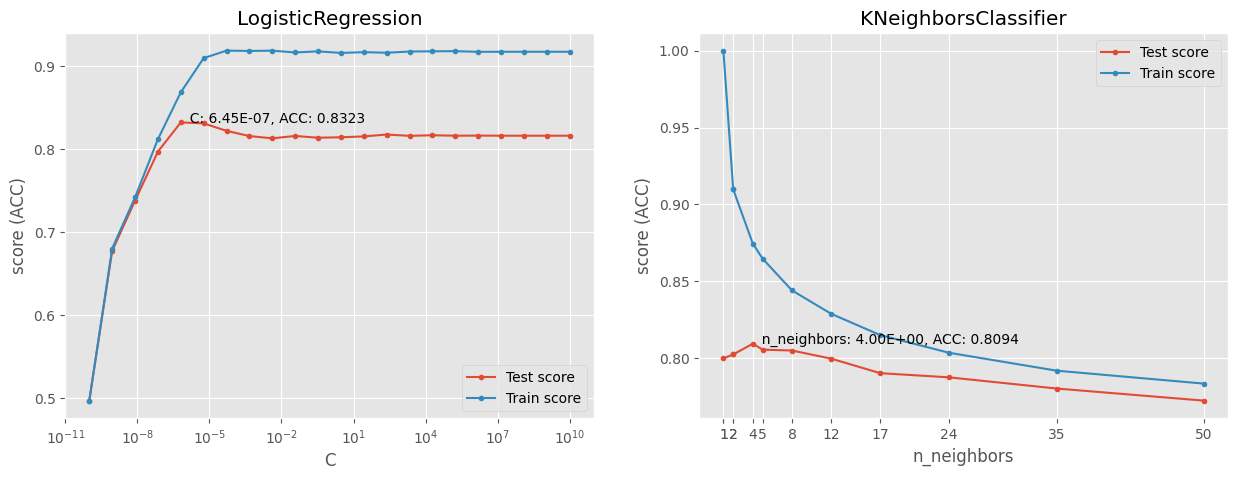

In [66]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
for grid_search, param, ax in zip(grid_searches,['C','n_neighbors'],axes):
    plot_tuning(grid_search, param, ax)

Interpret the plots. When are the methods underfitting? When are they overfitting? How sensitive are they to the regularization hyperparameter?

* ## Logistic regression:
    * **Underfitting**
  when the value of `C` is less than $10^{-10}$.  This can be seen from the fact that the (Train score) is very low on the leftmost part of the graph.

    * **Overfitting**
  The model starts to be overfitting when the value of `C` is higher than $10^{-4}$.

    * **Sensitivity**
    The model appears to be sensitive to the regularization hyperparameter `C`.

* ## KNN:

    * **Overfitting**
    The model seems to be overfitting when the value of `n_neighbours` is around 1-4.

    * **Sensitivity**
    The model seems not to be so much sensitive to the value of `n_neighbours` because the test score does not change much across the different values.

## Interpreting misclassifications
We train a logistic regression model on the data to look at the confusion matrix

In [67]:
# Create a stratified train-test split on a sample
X_train, X_test, y_train, y_test = train_test_split(Xs,ys, stratify=ys, random_state=0)

In [68]:
# model implementation:
model = LogisticRegression(C=1e-7, max_iter=1000).fit(X_train,y_train)
y_pred = model.predict(X_test)

### Question 3
A confusion matrix shows the amount of examples in for each pair of true and predicted classes. Interpret the results. Draw the complete confusion matrix for the true and predicted test data.

In [69]:
#### Code for calculating the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

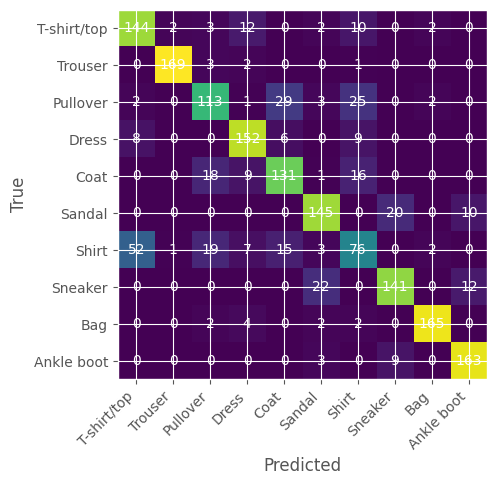

In [70]:
fig, ax = plt.subplots()
im = ax.imshow(cm)
ax.set_xticks(np.arange(10)), ax.set_yticks(np.arange(10))
ax.set_xticklabels(list(fmnist_classes.values()), rotation=45, ha="right")
ax.set_yticklabels(list(fmnist_classes.values()))
ax.set_ylabel('True')
ax.set_xlabel('Predicted')
for i in range(100):
    ax.text(int(i/10),i%10,cm[i%10,int(i/10)], ha="center", va="center", color="w")

## Interpreting model parameters
Finally, we'll take a closer look at the model parameters, i.e. the coefficients of our linear models. Since we are dealing with 28x28 pixel images, we have to learn 784 coefficients. What do these coefficients mean? We'll start by plotting them as 28x28 pixel images.

### Question 4
Train a Logistic Regression model using its tuned hyperparameter from gridsearch used above.
When in doubt, use `C=1e-7` for LogReg.
Pass the trained model to the provided plotting function. Interpret the results in detail.
Why do you get multiple plots per model? What do the features represent in your data.
Does it seems like the models pay attention to the right features?
Do you models seem to ignore certain features? Do you observe differences in quality between the different classes?

In [71]:
# Plots the coefficients of the given model as 28x28 heatmaps.
# The `name` attribute is optional, it is simply a title for the produced figure
def plot_coefficients(model, name=None):
    fig, axes = plt.subplots(1,10,figsize=(20,2))
    fig.suptitle(name if name else model.__class__.__name__)
    for i, ax in enumerate(axes):
        m = ax.imshow(model.coef_[i].reshape(28,28))
        ax.set_xlabel(fmnist_classes[i])
        ax.set_xticks(()), ax.set_yticks(())
    fig.colorbar(m, ax=axes.ravel().tolist())

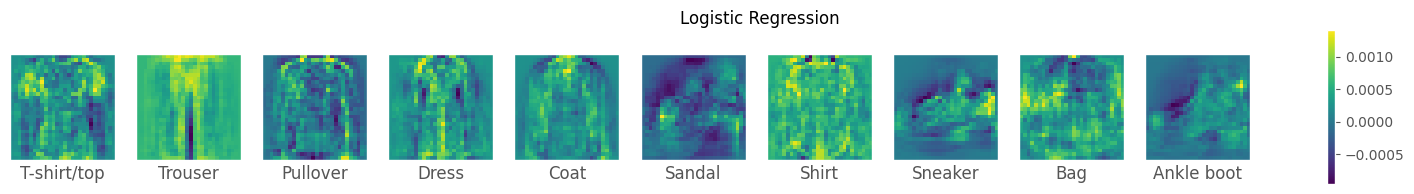

In [74]:
##### Call on the function plot_coefficients using your trained model
log_reg_model = LogisticRegression(C=6.45e-7, max_iter=1000)

log_reg_model.fit(X_train, y_train)

# Pass the trained model to the plot_coefficients function
plot_coefficients(log_reg_model, name="Logistic Regression")

**Hint** that linear models are typically binary classifiers. They will solve multi-class problems in a one-vs-all approach. Hence, for a 10-class problem, they will build 10 models, each one trained to predict whether an instance is from a specific class or not. This leads to 10 sets of 784 trained coefficients. Above, we plot them as 28x28 matrices, such that each coefficient is plotted at the location of their corresponding pixel value.

**Answer:**

* ### Why do you get multiple plots per model?

  Beacause changing the hyperparameter of the model may leads to changes to the overall perofamnce of it on unseen data, as we are dealing with a multi-class problem there is a separate set of coefficients for each class.

* ### What do the features represent in your data?

  In the context of image data, each feature represents the pixel intensity at a specific location in the image. these intensity values are the features used by the model.

* ### Does it seem like the models pay attention to the right features?

  From observations of the plot, brighter regions may indicate higher coefficient values, suggesting that those features are more influential in making predictions. it seems that the model performs better on some classes than on others in detecting edges and patterns.

* ### Do your models seem to ignore certain features?

  If certain features are not relevant for making predictions, the corresponding coefficients may appear close to zero or very small in magnitude. like in case of 'Sandal' or 'Sneaker' calsses, the edges are not clear from the whole image.

* ### Do you observe differences in quality between the different classes?

  Yes, there is differences in the quality of coefficients between different classes. Some classes may have clearer, while others may have less distinct features.

### Question 5
Finally, out of curiosity, let's see the result of underfitting and overfitting on the learned coefficients:
Repeat the previous exercise, only with logistic regression. In addition to a tuned version, also add a model that overfits a lot and one that underfits a lot.

In the cell below replace the ####### with your trained models with different alphas.

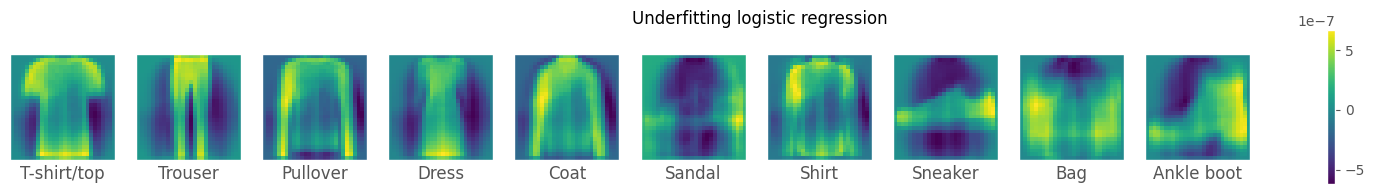

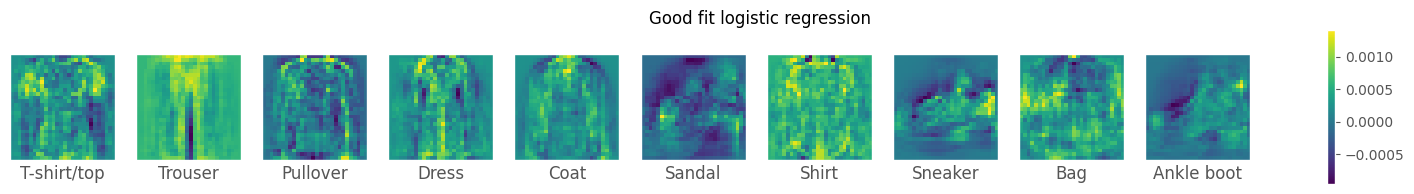

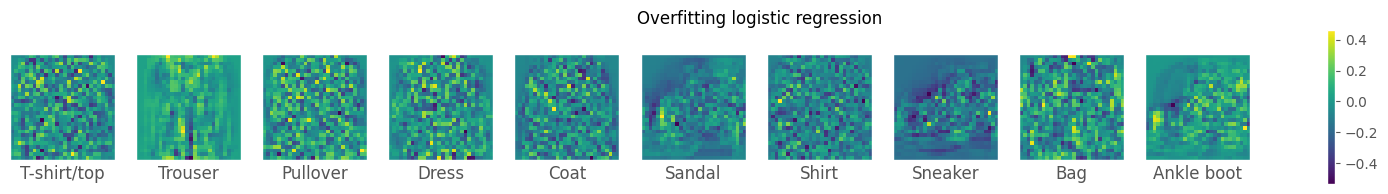

In [75]:
# Define logistic regression models with different levels of regularization
underfitting_model = LogisticRegression(C=1e-11, max_iter=1000)
good_fit_model = LogisticRegression(C=6.45e-7, max_iter=1000)
overfitting_model = LogisticRegression(C=1e7, max_iter=1000)

# Train the models
underfitting_model.fit(X_train, y_train)
good_fit_model.fit(X_train, y_train)
overfitting_model.fit(X_train, y_train)

# Plot the coefficients for each model
plot_coefficients(underfitting_model, "Underfitting logistic regression")
plot_coefficients(good_fit_model, "Good fit logistic regression")
plot_coefficients(overfitting_model, "Overfitting logistic regression")

# C_values = [1e-11, 1e-9, 1e-7, 1e-5, 1e-2, 1, 1e02, 1e06]
# for C_val in C_values:
#   model = LogisticRegression(C=C_val, class_weight="balanced")
#   model.fit(X_train, y_train)  # Train the model
#   plot_coefficients(model, f"logistic regression with C value {C_val}")


Interpret and explain the results.
* **Answer:**
From observations on the plots, very low values of `C` such as $10^{-11}$ which means very high regularization parameter may lead to underfitting. on other very high values of `C` such as $10^{7}$ which means very low regularization parameter may lead to overfitting.

# Part 2

In this part, you will use a bank dataset that predicts customer response to telemarketing campaigns for term deposit.

You should follow the workflow we described in class to use logistic regression to train on the data

1. Train - Test split (80-20%)
    - Study and handle any imbalance in the data's target
2. Data Exploration and cleaning
    - Remove duplicates
    - Handle outliers
    - Handle missing values
    - Handle categorical data
    
    (dont forget to apply the same preprocessing to the test set!)
3. Model selection --> Select the best model:
    - Train an l2 regularized logistic regression model
        - Use crossvalidation with grid search to set the learning rate and the regularization hyperparameters
    - Train a logistic regression model without regullarization
        - Use crossvalidation with grid search to set the learning rate  hyperparameter
    - Don't forget normalization of features!
4. Test the chosen model on the test data
5. Interpret the results using confusion matrix --> how does it do on each class?

### Attribute information For bank dataset

### Input variables:
**Bank client data:**
*   1 - age : (numeric)
*   2 - job : type of job (categorical: "admin.", "unknown", "unemployed", "management", "housemaid", "entrepreneur", "student", "blue-collar", "self-employed", "retired", "technician", "services")
*   3 - marital : marital status (categorical: "married", "divorced", "single"; note: "divorced" means divorced or widowed)
*   4 - education (categorical: "unknown", "secondary","primary", "tertiary")
*   5 - default: has credit in default? (binary: "yes", "no")
*   6 - balance: average yearly balance, in euros (numeric)
*   7 - housing: has housing loan? (binary: "yes", "no")
*   8 - loan: has personal loan? (binary: "yes", "no")
  
**Related with the last contact of the current campaign:**
*   9 - contact: contact communication type (categorical: "unknown","telephone","cellular")
*  10 - day: last contact day of the month (numeric)
*  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
*  12 - duration: last contact duration, in seconds (numeric)
   
**Other attributes:**
*  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
*  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
*  15 - previous: number of contacts performed before this campaign and for this client (numeric)
*  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown", "other", "failure", "success")

- The Output variable - y - describes whether the client has subscribed to a term deposit or not, ("yes" or "no")

## Import necessary librairies

In [1]:
# %pip install imbalanced-learn

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy.stats import yeojohnson
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

## Data loading and EDA

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/MohamedMandour10/Datasets/main/Mohammed%20AbuMandour%20-%20bank-full.csv", sep=';')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [3]:
print("Description of data")
display(df.describe())
print('*'* 50)
print("Data Info")
display(df.info())

Description of data


,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


**************************************************
Data Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


None

In [4]:
# Calculate cardinality for each column
cardinality = df.nunique()
cardinality

age            77
job            12
marital         3
education       4
default         2
balance      7168
housing         2
loan            2
contact         3
day            31
month          12
duration     1573
campaign       48
pdays         559
previous       41
poutcome        4
y               2
dtype: int64

In [5]:
# Check for duplicates
duplicate_rows = df.duplicated()
if duplicate_rows.any():
    print("Duplicate rows found:")
    print(df[duplicate_rows])
else:
    print("No duplicate rows found.")

No duplicate rows found.


In [6]:
# Assure that numerical features has a reasonable min values
min_values = df.select_dtypes(include=['number']).min()
print(min_values)

age           18
balance    -8019
day            1
duration       0
campaign       1
pdays         -1
previous       0
dtype: int64


In [7]:
# Assure that numerical features has a reasonable max values
max_values = df.select_dtypes(include=['number']).max()
print(max_values)

age             95
balance     102127
day             31
duration      4918
campaign        63
pdays          871
previous       275
dtype: int64


In [8]:
# Map months names to numerical numbers
month_mapping = {
    'jan': 1,
    'feb': 2,
    'mar': 3,
    'apr': 4,
    'may': 5,
    'jun': 6,
    'jul': 7,
    'aug': 8,
    'sep': 9,
    'oct': 10,
    'nov': 11,
    'dec': 12
}

df.month = df.month.map(month_mapping)

## Data Visualisation

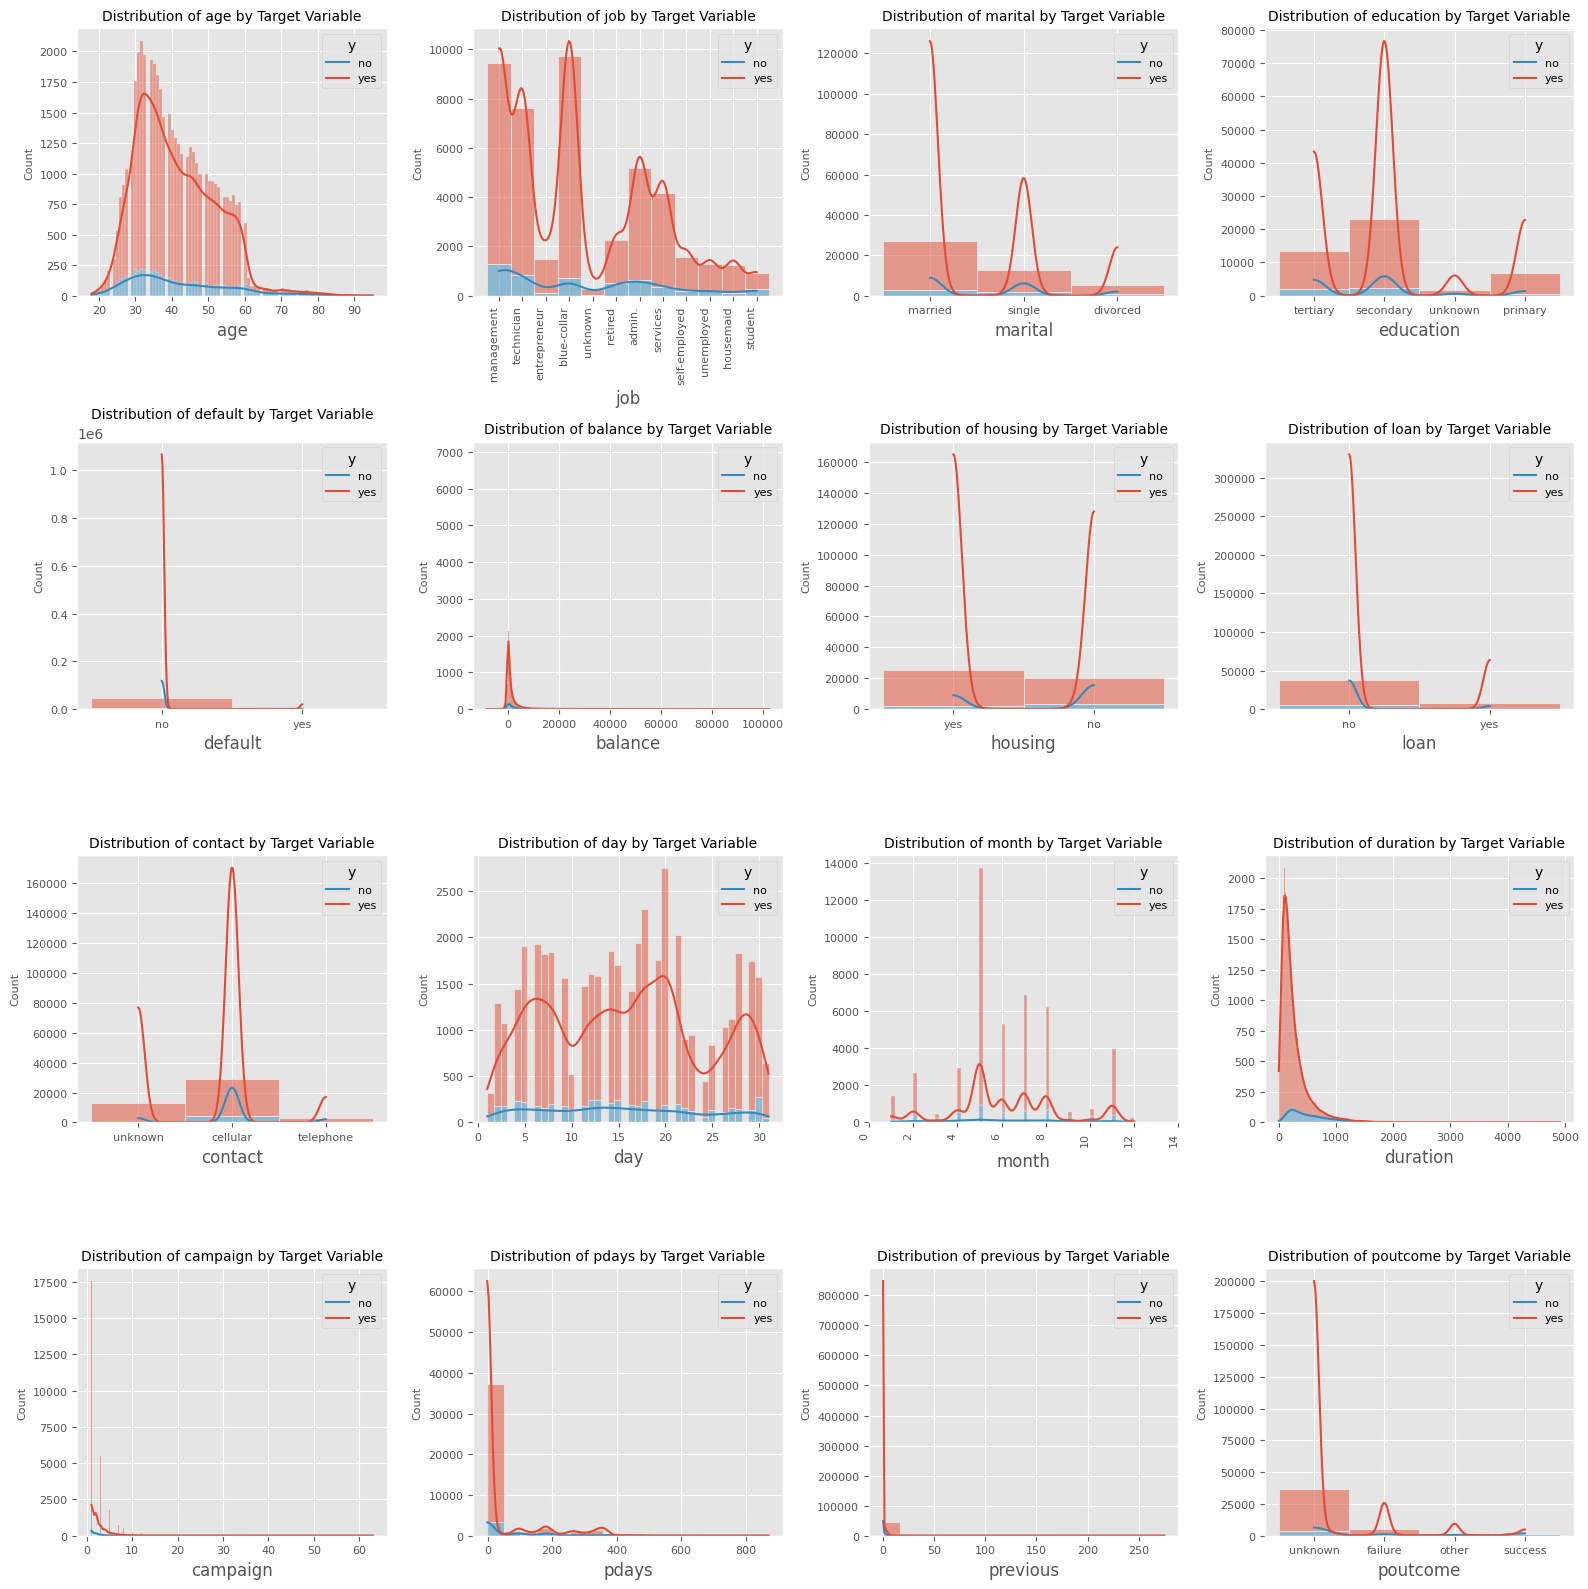

In [9]:
def plot_feature_distributions(df, target_column):
    """
    Plot the distribution of each feature given the target variable "y" on the same axis.

    Parameters:
    - df: DataFrame
        The DataFrame containing the data.
    - target_column: str
        The name of the target column (e.g., "y").

    Returns:
    - None
    """
    # Get all columns except the target column
    features = df.columns[df.columns != target_column]

    # Determine the number of rows and columns for the subplot grid
    n_cols = 4
    n_rows = (len(features) + n_cols - 1) // n_cols

    # Plot the distribution of each feature
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 16))
    for i, feature in enumerate(features):
        ax = axes[i // n_cols, i % n_cols]
        sns.histplot(data=df, x=feature, hue=target_column, multiple="stack", alpha=0.5, kde=True, ax=ax)
        ax.set_title(f"Distribution of {feature} by Target Variable", fontsize=10)
        ax.set_ylabel("Count", fontsize=8)

        # Add legend with labels for each class of the target variable
        ax.legend(title=target_column, labels=df[target_column].unique(), fontsize=8)

        # Decrease font size of x and y axis values
        ax.tick_params(axis='x', labelsize=8)
        ax.tick_params(axis='y', labelsize=8)

        # Tilt x-axis labels by 45 degrees
        if feature == "job" or feature == "month" :
            ax.set_xticks(ax.get_xticks())
            ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right', fontsize=8)

    # Adjust layout
    plt.tight_layout()

plot_feature_distributions(df, "y")

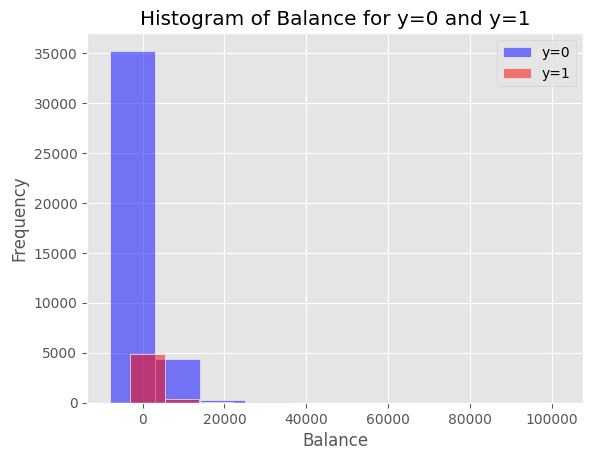

In [10]:
# Filter DataFrame for y=0
df_y0 = df[df['y'] == "no"]

# Filter DataFrame for y=1
df_y1 = df[df['y'] == "yes"]

# Plot histograms for y=0 and y=1 on the same graph
sns.histplot(df_y0['balance'], bins=10, color='blue', alpha=0.5, label='y=0')
sns.histplot(df_y1['balance'], bins=10, color='red', alpha=0.5, label='y=1')

# Add labels and legend
plt.xlabel('Balance')
plt.ylabel('Frequency')
plt.title('Histogram of Balance for y=0 and y=1')
plt.legend()

# Show plot
plt.show()

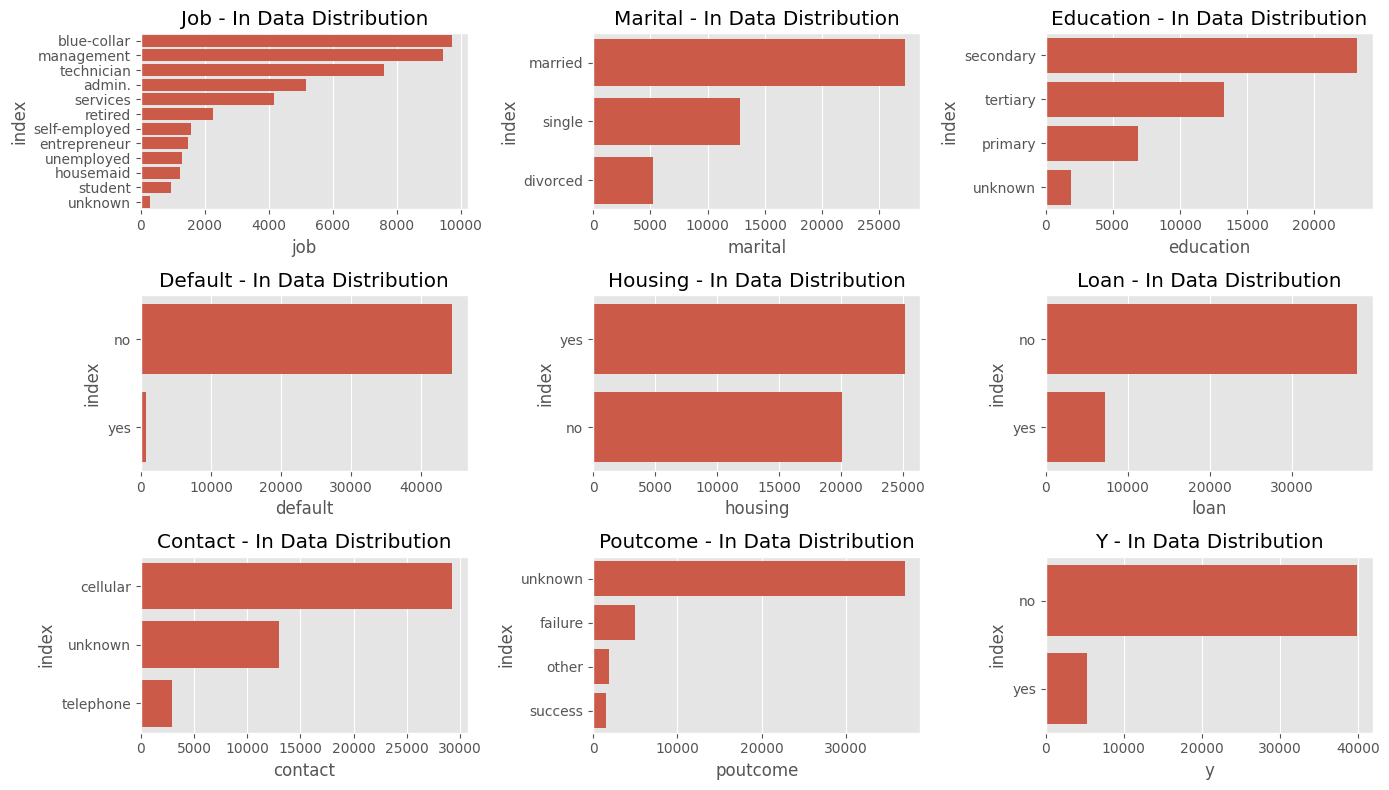

In [11]:
#Visualizations of categorical column in data distribution
cat_cols = [col for col in df.columns if df[col].dtype=='object' and col != 'date_month']

fig, axs = plt.subplots(3, 3, figsize=(14, 8))
axs = axs.flatten()

for i, col in enumerate(cat_cols):
    data = df[col].value_counts().reset_index()
    sns.barplot(data=data, y='index', x=col, ax=axs[i])
    axs[i].set_title(f'{col.title()} - In Data Distribution')

plt.tight_layout()
plt.show()

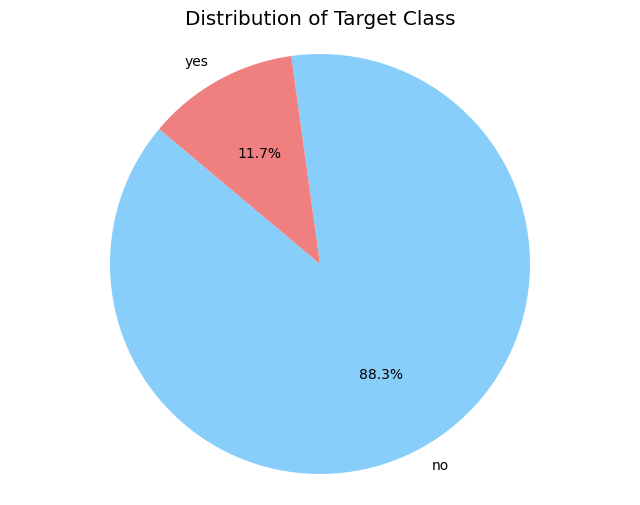

In [12]:
def draw_pie_chart(df, target_column):
    """
    Draw a pie chart of the target class with "yes" and "no" categories.

    Parameters:
    - df: DataFrame
        The DataFrame containing the data.
    - target_column: str
        The name of the target column (e.g., "y").

    Returns:
    - None
    """
    # Count the occurrences of "yes" and "no" in the target column
    counts = df[target_column].value_counts()

    # Create labels and sizes for the pie chart
    labels = counts.index
    sizes = counts.values

    # Define colors
    colors = ['lightskyblue', 'lightcoral']

    # Create a pie chart
    plt.figure(figsize=(8, 6))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.title('Distribution of Target Class')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.show()

draw_pie_chart(df, "y")

## Baseline Model
A baseline model serves as a simple and often minimalistic point of reference for evaluating the performance of more complex models.

In [13]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
import warnings

# Suppress the warning
warnings.filterwarnings('ignore')

# Your existing code
# Split data into features and target
X = df.drop("y", axis=1)
y = df["y"]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a baseline dummy classifier
dummy_clf = DummyClassifier(strategy="stratified")

# Train the baseline model
dummy_clf.fit(X_train, y_train)

# Make predictions
baseline_predictions = dummy_clf.predict(X_test)

# Calculate accuracy
baseline_accuracy = accuracy_score(y_test, baseline_predictions)
report = classification_report(y_test, baseline_predictions, zero_division=1) # Set zero_division=1 to avoid warning

print("Baseline Model Accuracy:", baseline_accuracy)
print("Baseline Model classification_report:\n", report)


Baseline Model Accuracy: 0.7932102178480592
Baseline Model classification_report:
               precision    recall  f1-score   support

          no       0.88      0.89      0.88      7952
         yes       0.12      0.11      0.12      1091

    accuracy                           0.79      9043
   macro avg       0.50      0.50      0.50      9043
weighted avg       0.79      0.79      0.79      9043



### As expected due to the imbalence in the data, the model predicts well on majority class `0` but has a poor performance on minor class `1`.

## Add debt feature
istead of relying on negative values in balance feature, introducing new feature with positive values may help mpdel get more insights about data.

In [14]:
# Create 'debt' column based on conditions
df['debt'] = 0  # Initialize 'debt' column with zeros
debit_indices = df['balance'] < 0  # Find indices where balance is less than 0
df.loc[debit_indices, 'debt'] = df.loc[debit_indices, 'balance']  # Set 'debt' value where balance is less than 0
df.loc[debit_indices, 'balance'] = 0  # Set balance to 0 where it is less than 0

# Make 'debt' column contain positive values
df['debt'] = df['debt'].abs()
df["debt"].value_counts()

0       41445
1          50
2          25
3          22
97         17
        ...  
859         1
782         1
1007        1
687         1
1414        1
Name: debt, Length: 917, dtype: int64

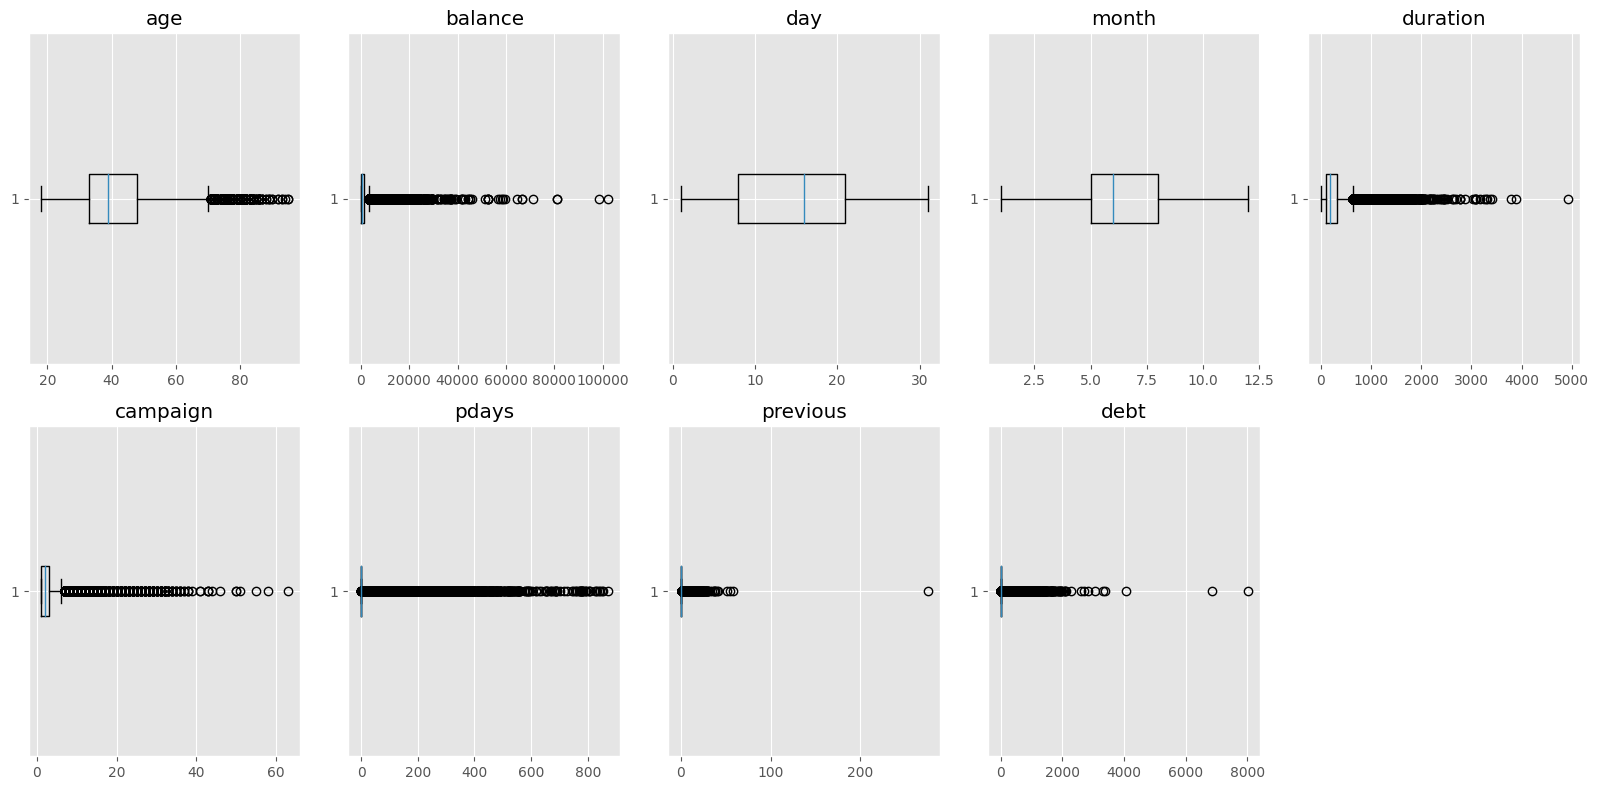

In [15]:
def draw_outliers_boxplot(df):
    numerical_features = df.select_dtypes(include=['number']).columns

    # Calculate the number of unique values for each numerical feature
    unique_counts = {}
    for feature in numerical_features:
        unique_counts[feature] = df[feature].nunique()

    # Filter features with more than two unique values
    features_to_plot = [feature for feature, count in unique_counts.items() if count > 2]

    num_features = len(features_to_plot)
    num_cols = 5  # Number of columns for the subplot layout
    num_rows = (num_features + num_cols - 1) // num_cols  # Compute the number of rows

    # Set up the figure size
    plt.figure(figsize=(16, num_rows * 4))

    # Draw boxplots for selected features
    for i, feature in enumerate(features_to_plot):
        plt.subplot(num_rows, num_cols, i+1)  # Adjust the subplot layout based on the number of features
        plt.boxplot(df[feature], vert=False)
        plt.title(feature)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


# Plot boxplots for standardized features
draw_outliers_boxplot(df)

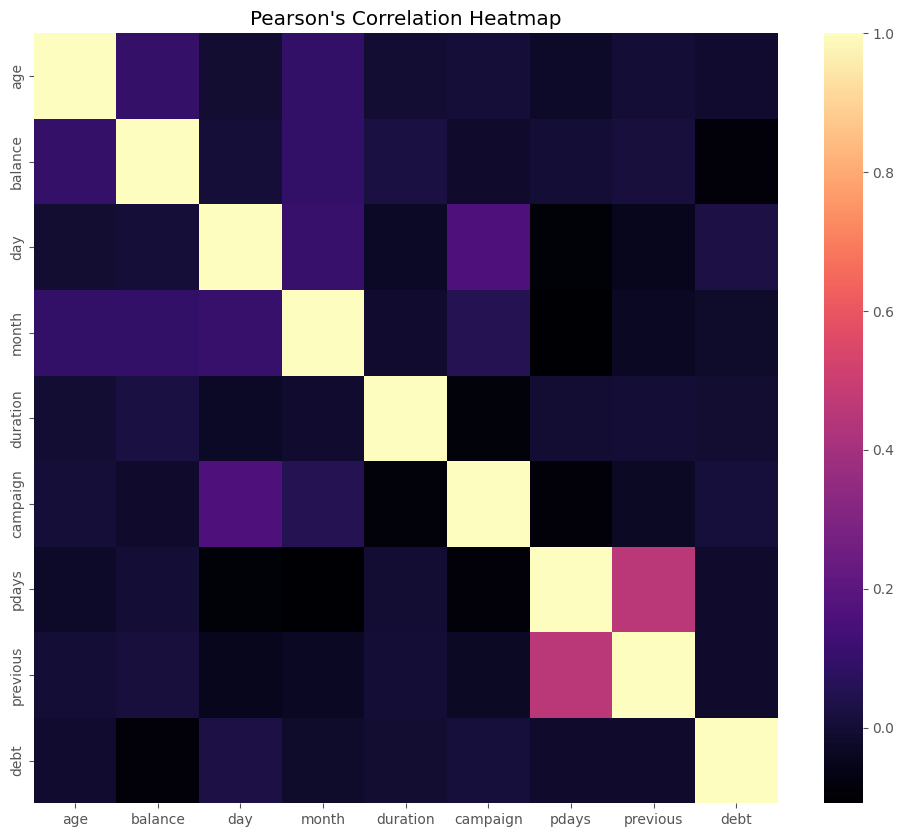

In [16]:
# Calculate Pearson's correlation coefficients
correlation_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='magma')
plt.title("Pearson's Correlation Heatmap")
plt.show()

## Handle Outliers

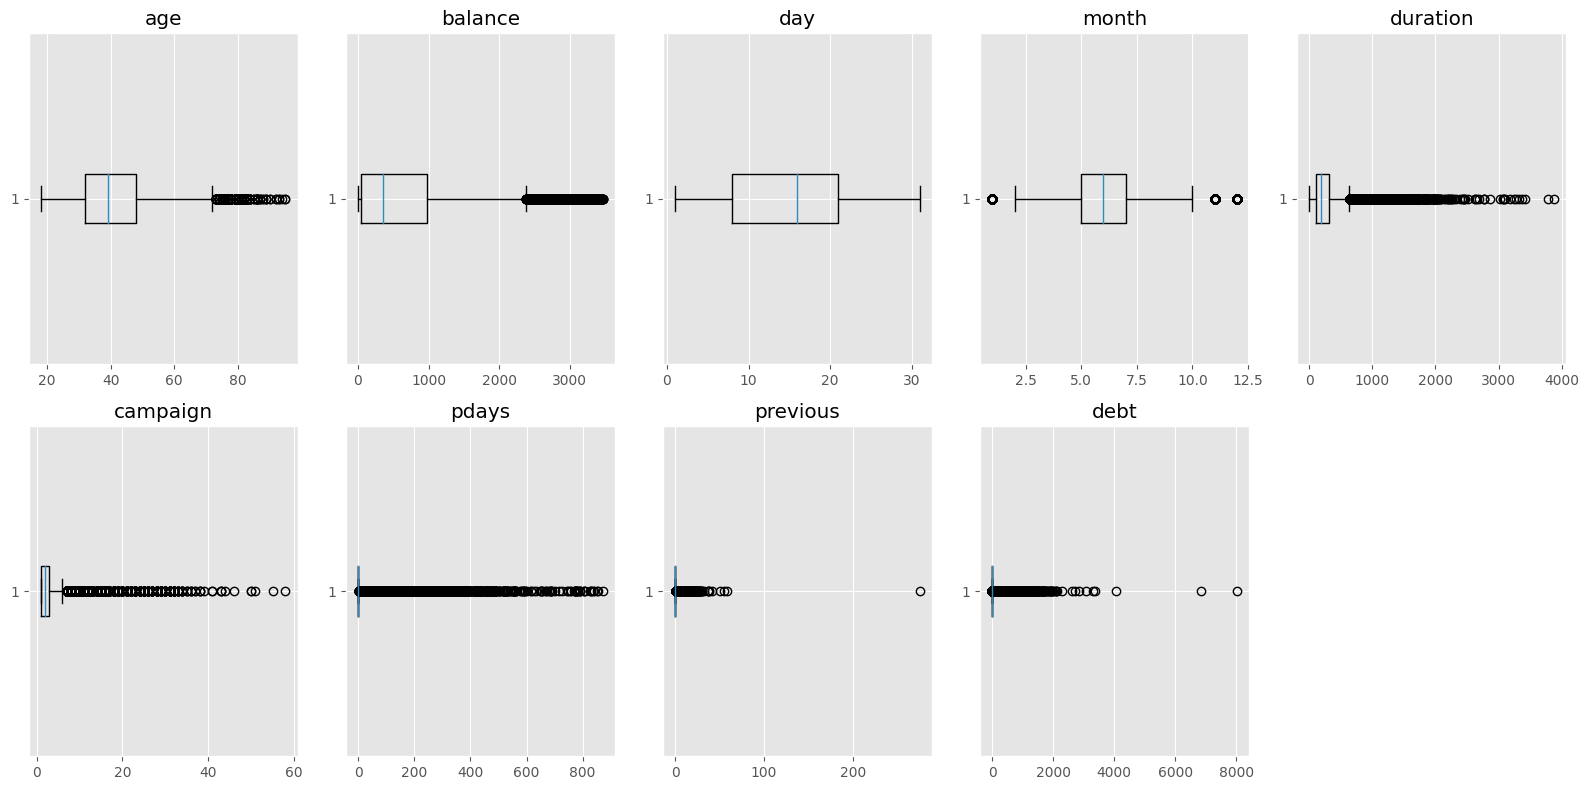

In [17]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Remove outliers from 'balance' column
df = remove_outliers_iqr(df.copy(), 'balance')
draw_outliers_boxplot(df)


## Handling categorical features
* Binary features transform to 0 and 1
* Map months names to numerical numbers
* use get_dummies to encode rest of categorical features

In [18]:
def handle_cat(dataframe):
  # Convert object columns to category
  for column in dataframe.select_dtypes(include=['object']).columns:
      dataframe[column] = dataframe[column].astype('category')

  # Convert binary categorical features to 0 and 1
  for column in dataframe.select_dtypes(include=['category']).columns:
      if dataframe[column].nunique() == 2:  # Check if the feature has only 2 unique categories
          dataframe[column] = dataframe[column].cat.codes  # Map categories to 0 and 1

  # apply label encoding to rest of categorical features
  data_cat = pd.get_dummies(dataframe, columns=['job', 'marital', 'contact', 'poutcome', 'education'], dtype="int8")
  return data_cat

df = handle_cat(df.copy())
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 40499 entries, 0 to 45210
Data columns (total 39 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   age                  40499 non-null  int64
 1   default              40499 non-null  int8 
 2   balance              40499 non-null  int64
 3   housing              40499 non-null  int8 
 4   loan                 40499 non-null  int8 
 5   day                  40499 non-null  int64
 6   month                40499 non-null  int64
 7   duration             40499 non-null  int64
 8   campaign             40499 non-null  int64
 9   pdays                40499 non-null  int64
 10  previous             40499 non-null  int64
 11  y                    40499 non-null  int8 
 12  debt                 40499 non-null  int64
 13  job_admin.           40499 non-null  int8 
 14  job_blue-collar      40499 non-null  int8 
 15  job_entrepreneur     40499 non-null  int8 
 16  job_housemaid        4

## Combining Random Oversampling and Undersampling

In [19]:
def plot_piecahrt(y_values, title):
  class_counts = sorted(Counter(y_values).items())

  # Extracting labels and counts from the class_counts
  labels = [str(cls) for cls, count in class_counts]
  counts = [count for cls, count in class_counts]

  # Plotting the pie chart
  plt.figure(figsize=(8, 6))
  plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
  plt.title(title)
  plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
  plt.show()

(21585, 33) (4317, 38) (21585,) (4317,)
shape of each class in target y before resampling [(0, 11512), (1, 5756)]
shape of each class in target y after resampling [(0, 14390), (1, 7195)]



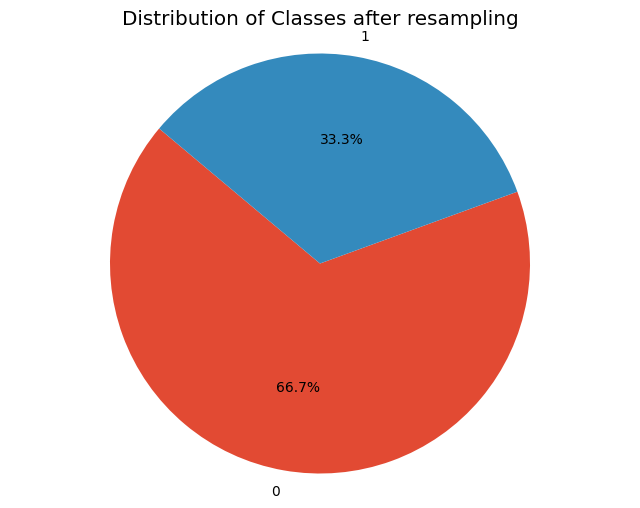

In [33]:
from imblearn.over_sampling import SMOTE


X = df.drop(columns=["y", "debt", "default", "day", "pdays", "previous"], axis=1)
y = df["y"]

# Define SMOTE oversampling strategy
smote = SMOTE(sampling_strategy=0.2, random_state=42, k_neighbors=3)
# Fit and apply the transform
X_smote, y_smote = smote.fit_resample(X, y)

# Define RandomUnderSampler undersampling strategy
under = RandomUnderSampler(sampling_strategy=0.5)

# fit and apply the transform
X_undersampled, y_undersampled = under.fit_resample(X_smote, y_smote )

print(X_undersampled.shape, X_test.shape, y_undersampled.shape, y_test.shape)
print("shape of each class in target y before resampling", sorted(Counter(y_train).items()))
print(f"shape of each class in target y after resampling {sorted(Counter(y_undersampled).items())}\n")

plot_piecahrt(y_undersampled, 'Distribution of Classes after resampling')

## Data spllitng and Handling Imbalance in data

In [34]:
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_undersampled, y_undersampled, train_size=0.8, stratify=y_undersampled, random_state=42, shuffle=True)

In [35]:
# Normalize features
scaler = RobustScaler()
X_train_undersampled_scaled = scaler.fit_transform(X_undersampled)
X_test_scaled = scaler.transform(X_test)

## Model Building and Training

### L2 Logistic Regression and non regulaized

In [36]:
# Model Selection

# L2 Regularized Logistic Regression
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid_search_l2 = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
grid_search_l2.fit(X_train_undersampled_scaled, y_undersampled)
best_l2_model = grid_search_l2.best_estimator_

# Logistic Regression without regularization
linear_model = LogisticRegression(max_iter=1000)
linear_model.fit(X_train_undersampled_scaled, y_undersampled)


print("Best Parameters:", grid_search_l2.best_params_)

Best Parameters: {'C': 0.1}


In [37]:
# Test the Chosen Model
y_pred_l2_under = best_l2_model.predict(X_test_scaled)
y_pred_no_reg_under = linear_model.predict(X_test_scaled)

# Classification Report
report = classification_report(y_test, y_pred_l2_under)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      2878
           1       0.86      0.72      0.78      1439

    accuracy                           0.87      4317
   macro avg       0.87      0.83      0.84      4317
weighted avg       0.87      0.87      0.86      4317



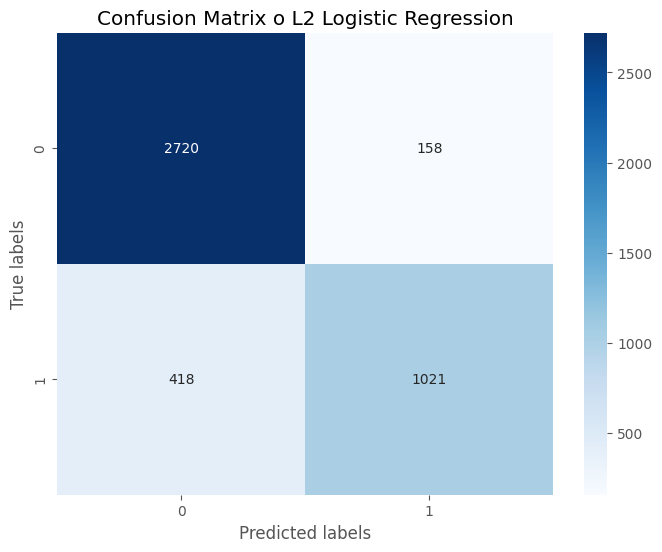

In [38]:
def plot_confusion(cm, title):
  # Plot confusion matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
  plt.title(title)
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.show()

cm = confusion_matrix(y_test, y_pred_no_reg_under)
plot_confusion(cm, 'Confusion Matrix o L2 Logistic Regression')

### L2 SGD Model

In [39]:
from sklearn.linear_model import SGDClassifier

# Define the parameter grid including learning rate
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1],  # Regularization parameter
              'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
              'eta0': [0.1, 0.01, 0.001]}  # Initial learning rate

# Perform grid search with logistic regression using SGD
grid_search_l2_sgd = GridSearchCV(SGDClassifier(loss='log_loss', max_iter=1000, n_jobs= -1), param_grid, cv=5)
grid_search_l2_sgd.fit(X_train_undersampled_scaled, y_undersampled)
best_l2_sgd_model = grid_search_l2_sgd.best_estimator_

print("Best Parameters:", grid_search_l2_sgd.best_params_)

Best Parameters: {'alpha': 0.0001, 'eta0': 0.01, 'learning_rate': 'optimal'}


In [40]:
y_pred_L2_SGD= best_l2_sgd_model.predict(X_test_scaled)

# Classification Report
report = classification_report(y_test, y_pred_L2_SGD)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      2878
           1       0.88      0.69      0.77      1439

    accuracy                           0.86      4317
   macro avg       0.87      0.82      0.84      4317
weighted avg       0.87      0.86      0.86      4317



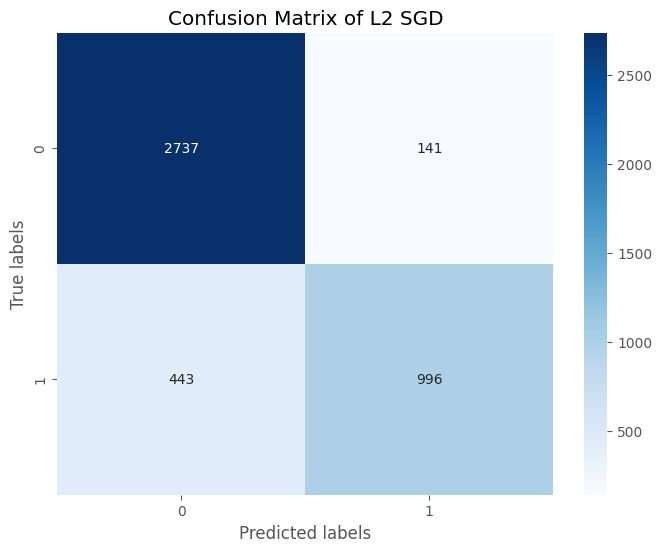

In [41]:
cm = confusion_matrix(y_test, y_pred_L2_SGD)
plot_confusion(cm, 'Confusion Matrix of L2 SGD')

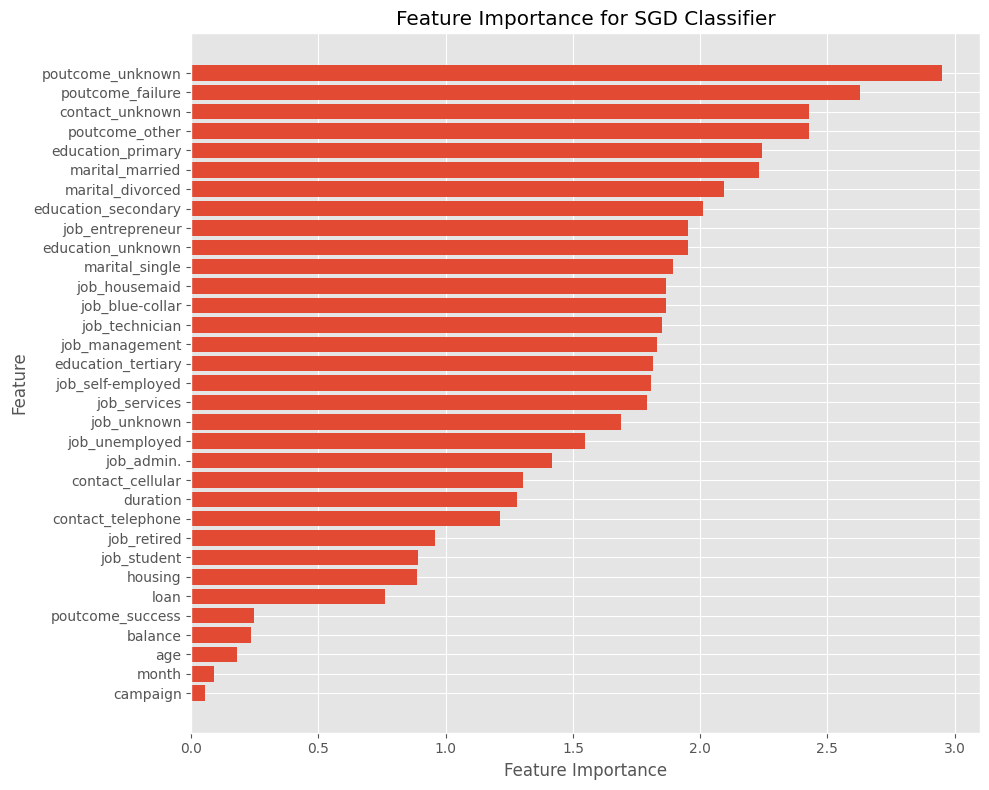

In [42]:
# Get the coefficients of the best SGD model
coefficients = best_l2_sgd_model.coef_[0]

feature_importance = np.abs(coefficients)

# Get the names of the features
feature_names = X_train.columns

# Sort feature importance and feature names in descending order
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_feature_importance)), sorted_feature_importance, align='center')
plt.yticks(range(len(sorted_feature_importance)), sorted_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for SGD Classifier')
plt.gca().invert_yaxis()  # Invert y-axis to display most important features at the top
plt.tight_layout()
plt.show()



From the Confusion Matrix:

* The model correctly predicted 2627 instances of class 0.
* The model incorrectly predicted 251 instances as class 1 when they were actually class 0.
* The model incorrectly predicted 359 instances as class 0 when they were actually class 1.
* The model correctly predicted 1080 instances of class 1.


### SGD Model without regularization

In [43]:
# Define the parameter grid including learning rate
param_grid = {'eta0': [0.1, 0.01, 0.001]}  # Initial learning rate

# Perform grid search with logistic regression using SGD without regularization
grid_search_sgd = GridSearchCV(SGDClassifier(loss='log_loss', max_iter=1000, alpha=0, learning_rate= 'constant'), param_grid, cv=5)
grid_search_sgd.fit(X_train_undersampled_scaled, y_undersampled)
best_sgd_model = grid_search_sgd.best_estimator_

print("Best Parameters:", grid_search_sgd.best_params_)

Best Parameters: {'eta0': 0.01}


In [44]:
y_pred_SGD= best_sgd_model.predict(X_test_scaled)

# Classification Report
report = classification_report(y_test, y_pred_SGD)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      2878
           1       0.85      0.75      0.80      1439

    accuracy                           0.87      4317
   macro avg       0.87      0.84      0.85      4317
weighted avg       0.87      0.87      0.87      4317



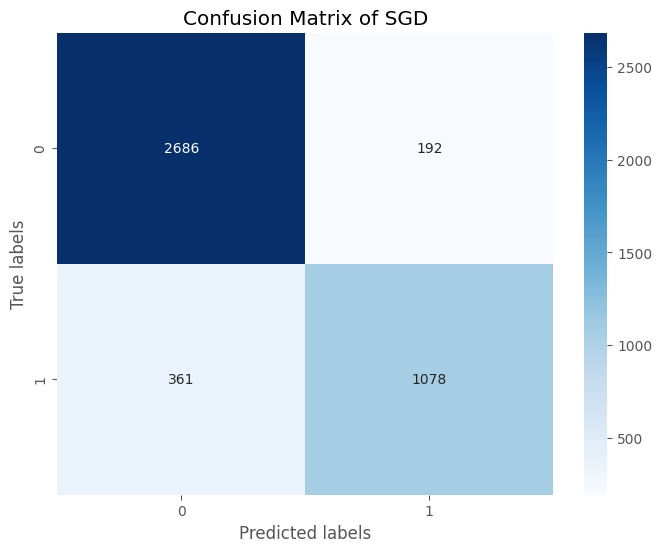

In [45]:
cm = confusion_matrix(y_test, y_pred_SGD)
plot_confusion(cm, 'Confusion Matrix of SGD')